<a href="https://colab.research.google.com/github/allen-del/Learning_PyTorch/blob/main/03.%20Computer%20Vision%20/%2003_CV_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises



## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [73]:
# Check for GPU
!nvidia-smi

Tue Jun 11 09:51:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              30W /  70W |    189MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [74]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code

#device = 'cpu'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device


2.3.0+cu121


'cuda'

## 1. What are 3 areas in industry where computer vision is currently being used?

1. Autonomous driving (Object tracking)
2. Healthcare - to identify cancerous cells (Image classification)
3. Image retrival and Image annotation

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Model fits too specifically (well) on training data and cannot make general predictions on other kinds of data. ie, Train Accuracy will be very high but Test Accuracy will not

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.


1. Early stopping and Train with more data
* Stop training the model before it starts to learn the noise in the training data and increase the number of relevant datapoints to learn the best relationship between features

2. Feature Selection
* Some features that are redundant should be eliminated and only the most relevant features must be kept.

3. Regularization
* Add a term in the loss function that penalizes having a large parameter space.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [75]:
import torchvision

from torchvision import datasets
from torchvision import models
from torchvision.transforms import v2

train_dataset = datasets.MNIST(root = 'data',
                                      train= True,
                                      download= True,
                                      transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                      target_transform=None)

test_dataset = datasets.MNIST(root = 'data',
                                     train=False,
                                     download= True,
                                     transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                     target_transform=None
                                     )

## 6. Visualize at least 5 different samples of the MNIST training dataset.

Train dataset length: 60000, Test dataset length: 10000






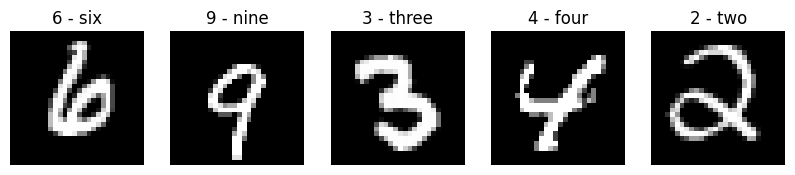

In [76]:
import matplotlib.pyplot as plt
import random

print(f"Train dataset length: {len(train_dataset)}, Test dataset length: {len(test_dataset)}\n\n\n\n")


class_names = train_dataset.classes
class_to_index = train_dataset.class_to_idx

fig = plt.figure(figsize=(10,7))

for i in range(5):


  random_index = random.randint(0, len(train_dataset))

  image, label = train_dataset[random_index]

  fig.add_subplot(1, 5, i+1)

  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False);


## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [77]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                            batch_size = BATCH_SIZE,
                             shuffle = False)

In [78]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [79]:
image_features_batch, image_labels_batch = next(iter(train_dataloader))
image_features_batch.shape, image_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [80]:
from torch import nn
class TinyVGG(nn.Module):

  def __init__(self, input_shape:int, output_shape:int, hidden_units:int):
    super().__init__()


    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )


    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels= hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )


  def forward(self, x: torch.Tensor):
    x=self.conv_block1(x)
    #print(f"Shape after Conv block 1: {x.shape}")
    x=self.conv_block2(x)
    #print(f"Shape after Conv bloc 2: {x.shape}")
    x=self.classifier_layer(x)
    #print(f"Shape after Classifier Layer: {x.shape} ")
    return x



In [81]:
INPUT_SHAPE=1
OUTPUT_SHAPE=len(class_names)
HIDDEN_UNITS=10
model_0 = TinyVGG(input_shape=INPUT_SHAPE,
                  output_shape=OUTPUT_SHAPE,
                  hidden_units=HIDDEN_UNITS
                  ).to(device)


In [82]:
torch.manual_seed(42)
rand_image_batch = torch.rand([32,1,28,28]).to(device)
rand_pred = model_0(rand_image_batch)

In [83]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists! Skipping download")

else:
  print("Downloading helper_functions.py")

  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)


from helper_functions import accuracy_fn
from helper_functions import print_train_time


helper_functions.py already exists! Skipping download


In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [85]:
def train_loop(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device
               ):

  from tqdm.auto import tqdm

  avg_loss, avg_accuracy = 0, 0
  model.train()

  for batch, (X, y) in enumerate(data_loader):

    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred = y_logits.argmax(dim=1)

    loss = loss_fn(y_logits, y)
    acc = accuracy_fn(y, y_pred)
    avg_loss+= loss
    avg_accuracy+= acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 600 == 0:

      print(f"Looked at {batch * len(X)} out of {len(data_loader)*BATCH_SIZE} images")

  avg_loss /= len(data_loader)
  avg_accuracy /= len(data_loader)

  print(f"Train Loss: {avg_loss : .4f},  Accuracy: {avg_accuracy: .3f}")



In [86]:
def test_loop(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              optimizer: torch.optim.Optimizer,
              device: torch.device = device):

  model.eval()

  avg_loss, avg_acc = 0, 0

  with torch.inference_mode():

    for X, y in iter(data_loader):

      X, y = X.to(device), y.to(device)

      y_logits = model(X)
      loss = loss_fn(y_logits, y)
      acc = accuracy_fn(y, y_logits.argmax(dim=1))

      avg_loss = avg_loss + loss
      avg_acc = avg_acc + acc

    avg_loss/= len(data_loader)
    avg_acc/=len(data_loader)

    print(f"Test loss: {avg_loss: .4f}, Accuracy: {avg_acc: .3f}")

In [87]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
from tqdm.auto import tqdm

start_time = timer()

epochs = 5

for epoch in tqdm(range(epochs)):

  print(f"_____________{epoch} Epochs _________________")

  train_loop(model=model_0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)


  test_loop(model_0,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            optimizer,
            device)

end_time = timer()

#train_time = {}

train_time[device] = print_train_time(start_time, end_time, device)

  0%|          | 0/5 [00:00<?, ?it/s]

_____________0 Epochs _________________
Looked at 0 out of 60000 images
Looked at 19200 out of 60000 images
Looked at 38400 out of 60000 images
Looked at 57600 out of 60000 images
Train Loss:  1.7377,  Accuracy:  37.027
Test loss:  0.3109, Accuracy:  90.325
_____________1 Epochs _________________
Looked at 0 out of 60000 images
Looked at 19200 out of 60000 images
Looked at 38400 out of 60000 images
Looked at 57600 out of 60000 images
Train Loss:  0.2053,  Accuracy:  93.600
Test loss:  0.1258, Accuracy:  96.056
_____________2 Epochs _________________
Looked at 0 out of 60000 images
Looked at 19200 out of 60000 images
Looked at 38400 out of 60000 images
Looked at 57600 out of 60000 images
Train Loss:  0.1267,  Accuracy:  96.155
Test loss:  0.1045, Accuracy:  96.615
_____________3 Epochs _________________
Looked at 0 out of 60000 images
Looked at 19200 out of 60000 images
Looked at 38400 out of 60000 images
Looked at 57600 out of 60000 images
Train Loss:  0.1023,  Accuracy:  96.957
Test l

In [92]:
train_time

{'cuda': 146.87634369600005, 'cpu': 321.330657688}

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

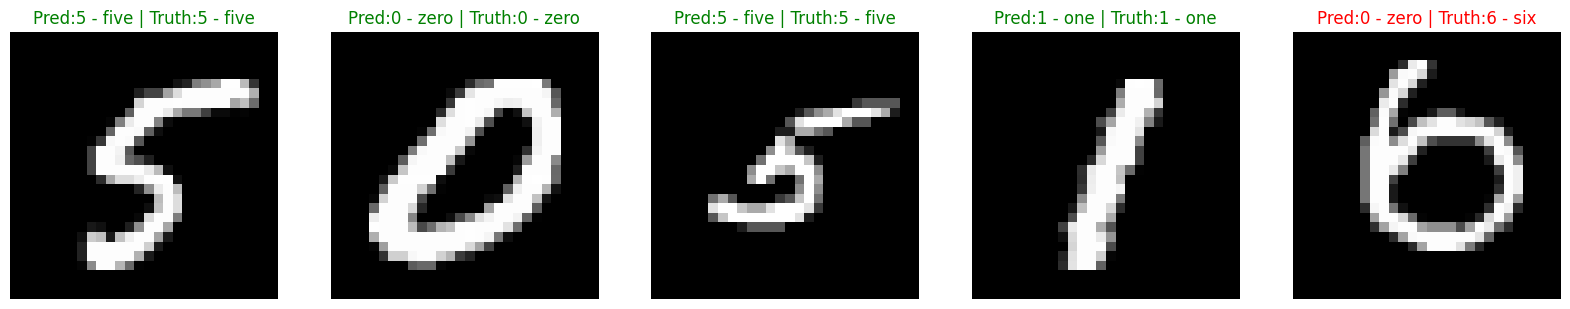

In [96]:
fig = plt.figure(figsize=(20,20))

for i in range(5):

  random_index = random.randint(0, len(test_dataset))

  image, label = test_dataset[random_index]

  image = image.to(device)

  y_pred = model_0(image.unsqueeze(dim=1)).argmax(dim=1)

  fig.add_subplot(1, 5, i+1)
  plt.imshow(image.squeeze().cpu(), cmap='gray')
  if y_pred == label:
    plt.title(f"Pred:{class_names[y_pred]} | Truth:{class_names[label]}", c='g')
  else:
    plt.title(f"Pred:{class_names[y_pred]} | Truth:{class_names[label]}", c='r')
  plt.axis(False);


## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [97]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [99]:
import mlxtend
import torchmetrics
from torchmetrics.classification import MulticlassConfusionMatrix
torchmetrics.__version__, mlxtend.__version__

('1.4.0.post0', '0.22.0')

In [100]:
y_preds = []

model_0.eval()
with torch.inference_mode():
  for X, y in iter(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model_0(X).squeeze().argmax(dim = 1)

    y_preds.append(y_pred.cpu()) #y_preds is a list now


In [101]:
y_preds = torch.cat(y_preds)
y_preds.shape #y_preds is a tensor now

torch.Size([10000])

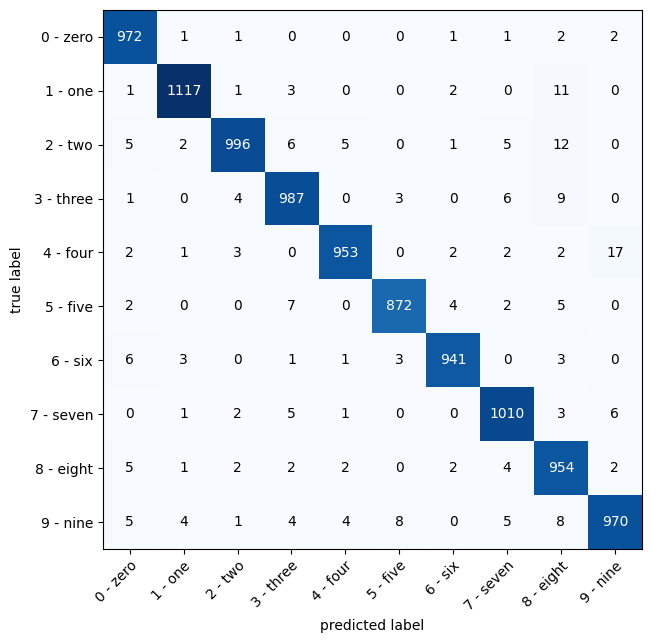

In [102]:
from mlxtend.plotting import plot_confusion_matrix
confmat = MulticlassConfusionMatrix(num_classes=len(class_names))

confmat_tensor = confmat(preds = y_preds,
                         target = test_dataset.targets)

fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize=(10,7))

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [103]:
random_tensor = torch.rand([1, 3, 64, 64])

KERNEL_SIZE = 1
PADDING = 1

ConvLayer = nn.Conv2d(in_channels = 3,
                      out_channels = 16,
                      kernel_size = KERNEL_SIZE,
                      padding=PADDING,
                      )

output_1 = ConvLayer(random_tensor)

print(output_1.shape)

KERNEL_SIZE = 2
PADDING = 1

ConvLayer = nn.Conv2d(in_channels = 3,
                      out_channels = 16,
                      kernel_size = KERNEL_SIZE,
                      padding=PADDING,
                      )

output_2 = ConvLayer(random_tensor)

print(output_2.shape)


torch.Size([1, 16, 66, 66])
torch.Size([1, 16, 65, 65])


## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [105]:
from torchvision import datasets

train_dataset = datasets.FashionMNIST(root = 'data',
                                      train=True,
                                      download=True,
                                      transform=v2.Compose([v2.ToImage(),v2.ToDtype(dtype=torch.float, scale = True)]),
                                      target_transform=None
                                      )

test_dataset = datasets.FashionMNIST(root = 'data',
                                     train=False,
                                     download=True,
                                     transform=v2.Compose([v2.ToImage(), v2.ToDtype(dtype = torch.float, scale = True)]),
                                     target_transform=None
                                     )



In [106]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [108]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)



In [113]:
model_1 = TinyVGG(input_shape = 1,
                  output_shape = 10,
                  hidden_units = 10).to(device)
model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [116]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [118]:
from tqdm.auto import tqdm

epochs = 5

for epoch in tqdm(range(epochs)):

  print(f"_____________ {epoch} Epochs _______________")

  train_loop(model_1,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device)

  test_loop(model_1,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)



  0%|          | 0/5 [00:00<?, ?it/s]

_____________ 0 Epochs _______________
Looked at 0 out of 60000 images
Looked at 19200 out of 60000 images
Looked at 38400 out of 60000 images
Looked at 57600 out of 60000 images
Train Loss:  0.3544,  Accuracy:  87.303
Test loss:  0.3404, Accuracy:  88.229
_____________ 1 Epochs _______________
Looked at 0 out of 60000 images
Looked at 19200 out of 60000 images
Looked at 38400 out of 60000 images
Looked at 57600 out of 60000 images
Train Loss:  0.3213,  Accuracy:  88.373
Test loss:  0.3403, Accuracy:  87.580
_____________ 2 Epochs _______________
Looked at 0 out of 60000 images
Looked at 19200 out of 60000 images
Looked at 38400 out of 60000 images
Looked at 57600 out of 60000 images
Train Loss:  0.3016,  Accuracy:  88.932
Test loss:  0.3333, Accuracy:  88.189
_____________ 3 Epochs _______________
Looked at 0 out of 60000 images
Looked at 19200 out of 60000 images
Looked at 38400 out of 60000 images
Looked at 57600 out of 60000 images
Train Loss:  0.2886,  Accuracy:  89.485
Test loss:

In [132]:
import numpy as np

y_preds = []

model_0.eval()
with torch.inference_mode():
  for X, y in iter(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model_0(X).squeeze().argmax(dim = 1)
    y_preds.append(y_pred.cpu())

y_preds = torch.cat(y_preds)

wrong_pred_indexes = np.where(y_preds != test_dataset.targets)[0]
len(wrong_pred_indexes)


9127

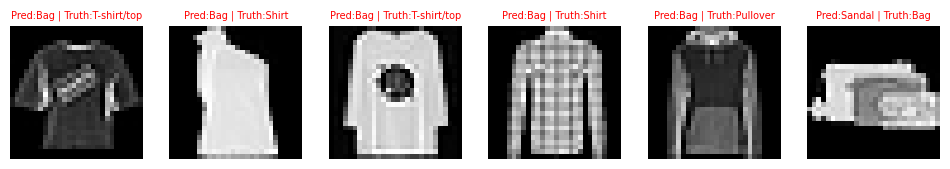

In [150]:
fig = plt.figure(figsize=(12, 12))

for i in range(6):

  random_wrong_index = wrong_pred_indexes[random.randint(0, len(wrong_pred_indexes))]

  image, label = test_dataset[random_wrong_index]
  image = image.to(device)
  y_pred = model_0(image.unsqueeze(dim=1)).argmax(dim=1)

  fig.add_subplot(1, 6, i+1)
  plt.imshow(image.squeeze().cpu(), cmap='gray')

  if y_pred == label:
    plt.title(f"Pred:{class_names[y_pred]} | Truth:{class_names[label]}", c='g', fontsize = 7)
  else:
    plt.title(f"Pred:{class_names[y_pred]} | Truth:{class_names[label]}", c='r', fontsize = 7)
  plt.axis(False);